In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [3]:
def equilRelVol(x,alpha):
    y = alpha*x/(1+(alpha-1)*x)
    return y
def colmodel(t,z,dd):
    # compositions
    N = dd['N']
    x = z[:N]
    xb = z[N]
    x0 = z[N+1]
    # equil calc
    y = equilRelVol(x,dd['alpha'])
    yb = equilRelVol(xb,dd['alpha'])
    # Liquid composition from tray above
    xim1 = np.hstack(( x0, x[:N-1] ))
    # Vapour composition from tray below
    yip1 = np.hstack(( y[1:], yb ))
    # Liquid flows
    LF = dd['L'] + np.hstack(( np.zeros(dd['Nf']), dd['F']*np.ones(N-dd['Nf']) )) #300+[0,0,0,0 350,350,350,350,350,350,350,350]
    FF = np.hstack(( np.zeros(dd['Nf']-1),1,np.zeros(N-dd['Nf']) )) *dd['F']      #[0,0,0,1,0,0,0,0,0,0,0,0]*350
    # tray composition balances
    dxdt = 1/dd['M']*(LF*(xim1-x) + dd['V']*(yip1-y) + FF*(dd['xfeed']-x))
    # boiler and drum composition balances
    dxbdt = 1/dd['Mb']*(LF[-1]*(x[-1]-xb) + dd['V']*(xb-yb))
    dx0dt = 1/dd['Mc']*(dd['V']*(y[0]-x0))
    # derivatives
    dzdt = np.hstack((dxdt,dxbdt,dx0dt))
    return dzdt

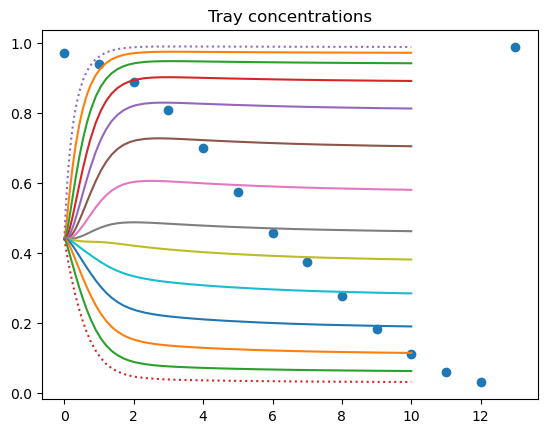

In [4]:
# PARAMETERS
dd = {}
# *** Equilibrium data
dd['alpha'] = 2.5
# *** Flows
# Feed
dd['F'] = 350 # kmole/h
dd['xfeed'] = 0.44 # mole fraction
# Reflux ratio
dd['RD'] = 3
dd['RV'] = 3
dd['B'] = 200
dd['D'] = dd['F']-dd['B']
dd['L'] = dd['RD']*dd['D']
dd['V'] = (1+dd['RV'])*dd['D']
# *** Column
# Tray numbering
N = 12
dd['N'] = N
dd['Nf'] = 7
dd['Nr'] = dd['Nf']-1 # rectifier
dd['Ns'] = N-dd['Nf'] # stripper
# Tray hold-up
dd['M'] = 20 # kmole
dd['Mc'] = 50
dd['Mb'] = 200
# Simulation
xinit=dd['xfeed']*np.ones(N+2)
ss_sol=fsolve(lambda x: colmodel(0,x,dd),xinit)
Tspan=[0, 10]
dyn_sol=solve_ivp(lambda t,x: colmodel(t,x,dd),Tspan,xinit, method='BDF', dense_output=True)
dd['ss'] = ss_sol
dd['dyn'] = dyn_sol
# Plot of tray concentrations
plt.figure()

plt.plot(ss_sol, 'o')
plt.plot(dyn_sol.t,dyn_sol.y[:N,:].T)
plt.plot(dyn_sol.t,dyn_sol.y[N:,:].T,':')
plt.title('Tray concentrations')
plt.show(block=False)

Text(0.5, 1.0, 'Column profile')

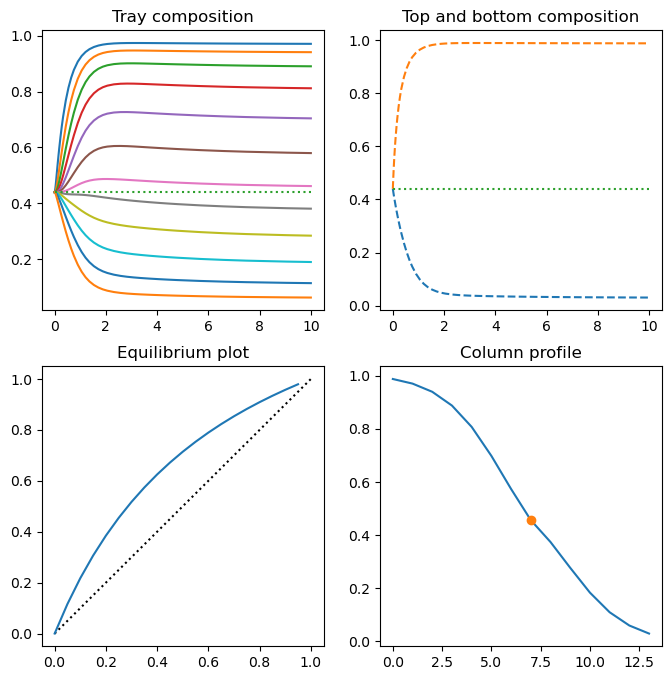

In [7]:
ss = dd['ss']
dyn = dd['dyn']
N = dd['N']
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax = ax.flatten()
ax[0].plot(dyn.t,dyn.y[:N,:].T)
ax[0].plot([0,dyn.t[-1]], dd['xfeed']*np.ones(2), ':')
ax[0].set_title('Tray composition')
ax[1].plot(dyn.t, dyn.y[N:N+2,:].T,'--')
ax[1].plot([0, dyn.t[-1]], dd['xfeed']*np.ones(2), ':')
ax[1].set_title('Top and bottom composition')

xj = np.arange(0, 1, 0.05) # start,stop, step
yj=equilRelVol(xj, dd['alpha'])
xx = np.zeros(2*(N+1)+1)
xx[::2] = np.hstack( (ss[N+1], ss[:N], ss[N]) )
xx[1::2] = np.hstack( (ss[:N], ss[N] ) )
ysol=equilRelVol(ss[:N+1],dd['alpha'])
yy = np.zeros(2*(N+1)+1)
yy[::2] = np.hstack( (ysol[:N], ysol[N], ss[N]) )
yy[1::2] = np.hstack( (ysol[:N], ysol[N]) )
ax[2].plot([0, 1],[0, 1],':k')
ax[2].plot(xj, yj)
ax[2].plot(xx, yy)
ax[2].set_title('Equilibrium plot')
ax[3].plot(np.arange(0,N+2), np.hstack((ss[N+1], ss[:N], ss[N])) ) # xsol(1:dd.N); xsol(dd.N+1)]
ax[3].plot(dd['Nf'], ss[dd['Nf']-1], 'o')
ax[3].set_title('Column profile')
